In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from cdlib import algorithms, evaluation
from graspy.simulations import sbm
from sklearn.metrics import normalized_mutual_info_score as NMI
from graspy.plot import heatmap
from community import modularity

# Helper Functions

In [2]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


# Generate synthetic data with the Stochastic Block Algorithm

In [3]:
np.random.seed(7)
s = [100,100,100,100,100]
p = [[.25,.025,.05,.033,.075],
     [.025,.175,.05,.01,.04],
     [.05,.05,.2,.025,.075],
     [.033,.01,.025,.175,.01],
     [.075,.04,.075,.01,.25]]
d = np.random.uniform(0.001,.01,int(sum(s)*.8))
dd = np.random.uniform(.01,.03,int(sum(s)*.2))
d = np.concatenate([d,dd])
d=d[np.random.permutation(d.shape[0])]
l=[0,1,2,3,4]
for i,j in zip(s,l):
    y=list(np.repeat(l,s))
    
dc = sbm(s,p,
         dc=d,
         )

ydict = {i:j for i,j in enumerate(y)}


/Users/abdullahsaid/cd/lib/python3.7/site-packages/graspy/simulations/simulations.py:538: UserWarning: Block 0 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)
/Users/abdullahsaid/cd/lib/python3.7/site-packages/graspy/simulations/simulations.py:538: UserWarning: Block 1 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)
/Users/abdullahsaid/cd/lib/python3.7/site-packages/graspy/simulations/simulations.py:538: UserWarning: Block 2 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)
/Users/abdullahsaid/cd/lib/python3.7/site-packages/graspy/simulations/simulations.py:538: UserWarning: Block 3 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)
/Users/abdullahsaid/cd/lib/python3.7/site-packages/graspy/simulations/simulations.py:538: UserWarning: Block 4 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)


# Visualize Communities

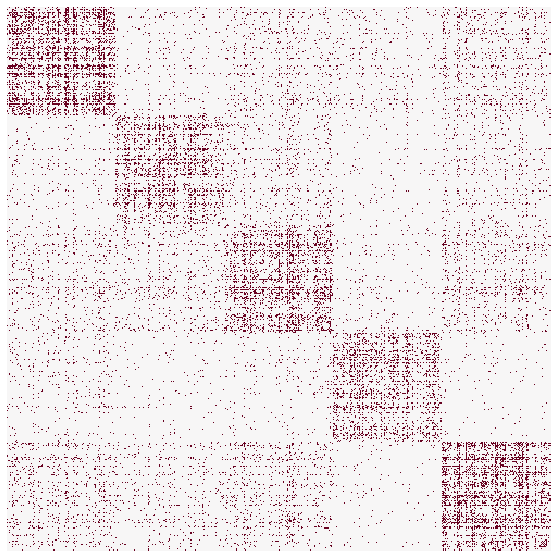

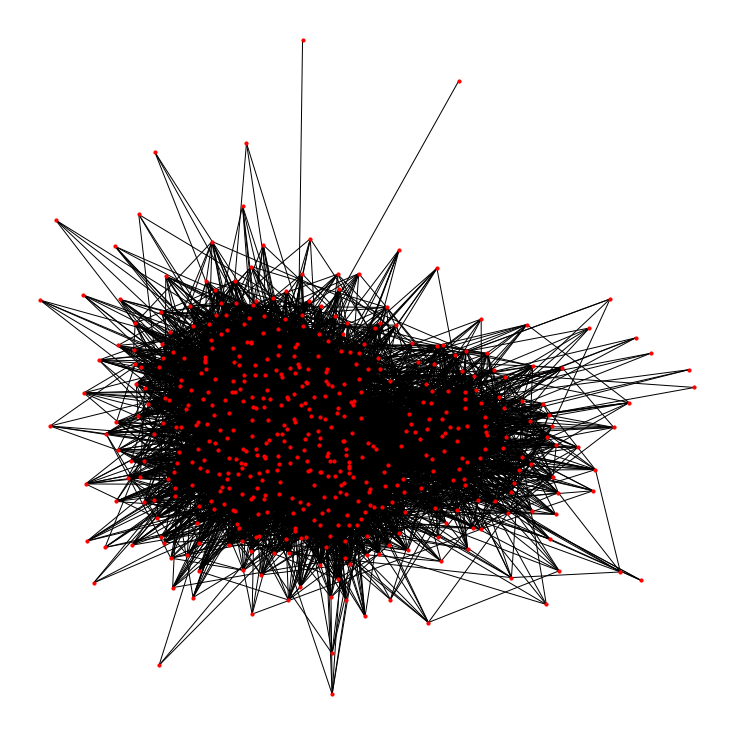

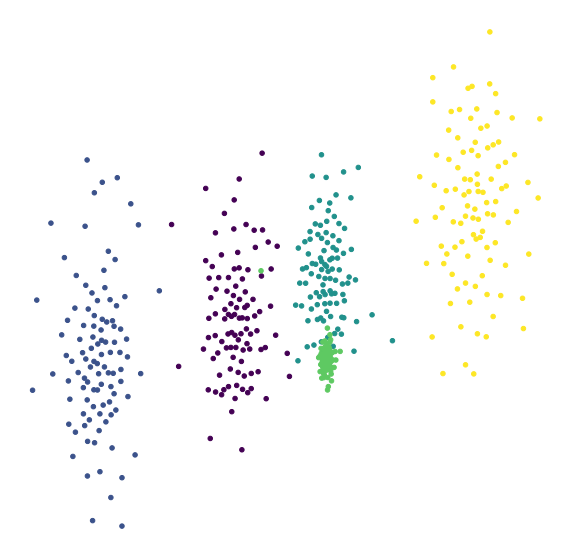

In [4]:
heatmap(dc,cbar=False,context='paper')

g = nx.from_numpy_matrix(dc)

plt.figure(figsize=(10,10))
nx.draw(g,node_color='red',node_size=10, with_labels =False)
plt.show()

pos = community_layout(g,ydict)
#pos = nx.spring_layout(g)
plt.figure(figsize=(10,10))

nx.draw_networkx_nodes(g, pos, node_color=y, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.05, edge_color='white')
plt.axis('off')
plt.show()


# Spectral Modularity Maximization 

Community size: 2, Modularity score: 0.2576, NMI: 0.5446
Community size: 3, Modularity score: 0.2894, NMI: 0.7042
Community size: 3, Modularity score: 0.2894, NMI: 0.7042
Community size: 3, Modularity score: 0.2894, NMI: 0.7042
Community size: 4, Modularity score: 0.3431, NMI: 0.8204
Community size: 5, Modularity score: 0.3551, NMI: 0.8995


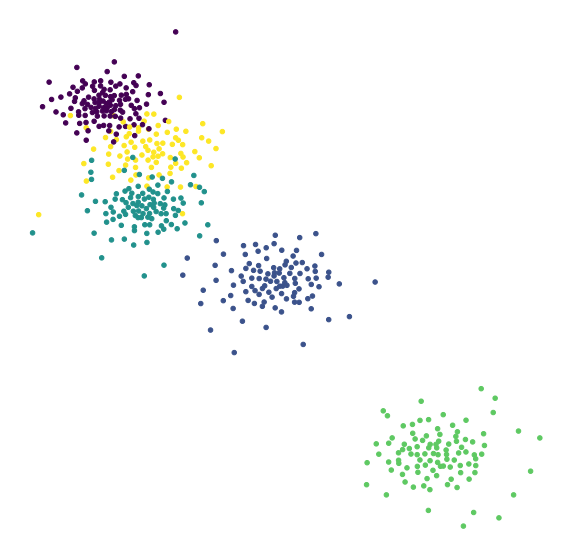

In [5]:

for i in range(2,8):
    c = algorithms.eigenvector(g,i)
    mod = evaluation.newman_girvan_modularity(g,c)
    cs = len(c.communities)
    pred = {}
    for i in range(len(c.communities)):
        for j in c.communities[i]:
            pred.update({j:i})
    
    yhat = [pred[i] for i in g.nodes()]
    
    nmi=NMI(y,yhat)
    print('Community size: {}, Modularity score: {:.4f}, NMI: {:.4f}'.format(cs,mod[2],
                                                                 nmi))


pos = community_layout(g,pred)
plt.figure(figsize=(10,10))
#nx.draw_networkx(g,node_color='red',node_size=20, with_labels =False)
nx.draw_networkx_nodes(g, pos, node_color=yhat, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.1, edge_color = 'white')
plt.axis('off')
plt.show()

# Louvain Algo

Community size: 5, Modularity score: 0.3658, NMI: 0.9721
Community size: 5, Modularity score: 0.3658, NMI: 0.9721
Community size: 5, Modularity score: 0.3658, NMI: 0.9721
Community size: 4, Modularity score: 0.3413, NMI: 0.8692
Community size: 5, Modularity score: 0.3658, NMI: 0.9721


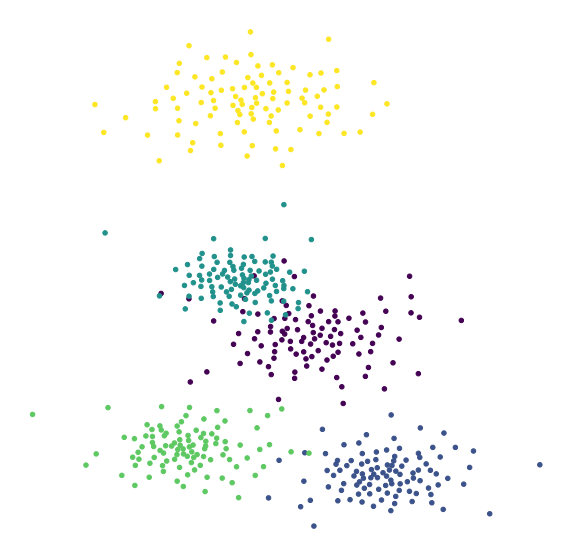

In [6]:
for i in range(1,6):
    c = algorithms.louvain(g,resolution=1,randomize=True)
    mod = evaluation.newman_girvan_modularity(g,c)
    cs = len(c.communities)
    pred = {}
    for i in range(len(c.communities)):
        for j in c.communities[i]:
            pred.update({j:i})
    
    yhat = [pred[i] for i in g.nodes()]
    
    nmi=NMI(y,yhat)
    print('Community size: {}, Modularity score: {:.4f}, NMI: {:.4f}'.format(cs,mod[2],
                                                                     nmi))

#cmap=ListedColormap(['r','g','b','c','m','darkred','k','pink','orange','mediumpurple','olive'])

pos = community_layout(g,pred)
plt.figure(figsize=(10,10))
#nx.draw_networkx(g,node_color='red',node_size=20, with_labels =False)
nx.draw_networkx_nodes(g, pos, node_color=yhat, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.1, edge_color = 'white')
plt.axis('off')
plt.show()


# LPA

Community size: 2, Modularity score: 0.1516, NMI: 0.4426


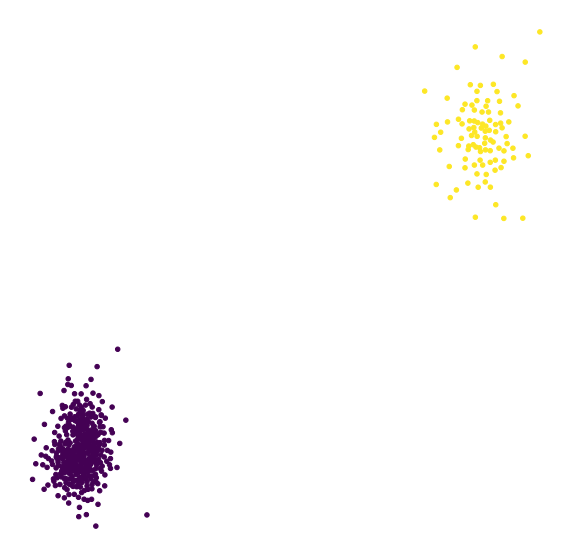

In [7]:
c = algorithms.label_propagation(g)
mod = evaluation.newman_girvan_modularity(g,c)
cs = len(c.communities)
pred = {}
for i in range(len(c.communities)):
    for j in c.communities[i]:
        pred.update({j:i})

yhat = [pred[i] for i in g.nodes()]

nmi=NMI(y,yhat)
print('Community size: {}, Modularity score: {:.4f}, NMI: {:.4f}'.format(cs,mod[2],
                                                                 nmi))
    

pos = community_layout(g,pred)
plt.figure(figsize=(10,10))
#nx.draw_networkx(g,node_color='red',node_size=20, with_labels =False)
nx.draw_networkx_nodes(g, pos, node_color=yhat, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.2, edge_color = 'white')
plt.axis('off')
plt.show()
